In [1]:
# Running on GPU?
import setGPU

import getpass
import h5py
import pickle
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm

from tqdm import tnrange, tqdm_notebook

setGPU: Setting GPU to: 1


In [2]:
import os
import getpass
# Get permission to access EOS (Insert your NICE password)
os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
import json
import numpy as np
import pandas as pd
from pprint import pprint

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.activations import sigmoid, linear, relu
from keras.models import Model, load_model
from keras.regularizers import l1, l2, l1_l2

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

Using TensorFlow backend.


In [4]:
plt.rcParams.update({'font.size': 22})

In [5]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 17

In [6]:
legend = [{"name": 'pf_jets', "start": 0, "end": 776},
          {"name": 'cal_jet_mets', "start": 777, "end": 944},
          {"name": 'pho', "start": 945, "end": 1280},
          {"name": 'muons', "start": 1281, "end": 1784},
          {"name": 'pf_jets2', "start": 1785, "end": 1889},
          {"name": 'pf_mets', "start": 1890, "end": 1917},
          {"name": 'nvtx', "start": 1918, "end": 1924},
          {"name": 'cal_jet_mets2', "start": 1925},
          {"name": 'sc', "start": 2037, "end": 2127},
          {"name": 'cc', "start": 2128, "end": 2169},
          {"name": 'pho2', "start": 2170, "end": 2365},
          {"name": 'muons2', "start": 2366, "end": 2491},
          {"name": 'ebs', "start": 2492, "end": 2701},
          {"name": 'hbhef', "start": 2702, "end": 2764},
          {"name": 'presh', "start": 2765, "end": 2806},
          {"name": 'inst_lumi', "start": 2807, "end": 2808}]

In [7]:
# Feature description
feature_names = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEnhfEM', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi', 'inst_luminosity']

In [8]:
data_directory = "/eos/project/c/cmsml4dc/fsiroky/consistentlumih5/"
label_file = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/jsons-generated/SingleElectron.json"
pileup_file = "/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions16/13TeV/PileUp/pileup_latest.txt"
model_directory = "/eos/user/t/tkrzyzek/autoencoder/p_coeff_study-allmean-singleelectron/"
model_name = "model_double_muon"

In [9]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [10]:
# Load good and bad jets
def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

Reading: SingleElectron_C_background
Reading: SingleElectron_D_background
Reading: SingleElectron_E_background
This Primary Dataset doesn't have SingleElectron_E_background. Unable to open file (Unable to open file: name = '/eos/project/c/cmsml4dc/fsiroky/consistentlumih5/singleelectron_e_background.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Reading: SingleElectron_F_background
This Primary Dataset doesn't have SingleElectron_F_background. Unable to open file (Unable to open file: name = '/eos/project/c/cmsml4dc/fsiroky/consistentlumih5/singleelectron_f_background.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Reading: SingleElectron_G_background
Reading: SingleElectron_H_background
Reading: SingleElectron_C_signal
Reading: SingleElectron_D_signal
Reading: SingleElectron_E_signal
This Primary Dataset doesn't have SingleElectron_E_signal. Unable to open file (Unable to open file: name = '/eos/project/c/cmsml

In [11]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

# Drop unnecessary meta data
data.drop([2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Append inst. luminosity at the end as well
data[2807] = data["inst_lumi"]

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)  

runIDs  = data["run"].astype(int)
lumiIDs = data["lumi"].astype(int)
luminosity = data["inst_lumi"].astype(float)

In [12]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [13]:
with open(pileup_file) as f:
    pileup = json.load(f)

def pileup_from_json(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid == i[0]:
                return i[3]
    except KeyError:
        print('key error')
    return 1

def add_pileup(sample):
    return pileup_from_json(pileup, sample["run"], sample["lumi"])

data["pileup"] = data.apply(add_pileup, axis=1)

In [14]:
data[2808] = data["pileup"]

In [32]:
RUN_FROM = 278769

# Take only continous data
data = data[data['run'] >= RUN_FROM]

# Split the data
TRAIN_FROM = round(0*len(data))
TRAIN_TO = round(0.5*len(data))
TEST_FROM = round(0.5*len(data))
TEST_TO = round(1*len(data))

train = data.iloc[TRAIN_FROM:TRAIN_TO]
X_train = pd.concat([train.iloc[:, :2808], train[2808]], axis=1)
y_train = train["label"]

test = data.iloc[TEST_FROM:TEST_TO]
X_test = pd.concat([test.iloc[:, :2808], test[2808]], axis=1)
y_test = test["label"]

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Train only on good
X_train = X_train[y_train == 0]
X_train_norm = X_train_norm[y_train == 0]

In [33]:
X_train_norm.shape

(32722, 2809)

In [34]:
def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "topn_median":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.median(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)
    
    elif mode == "bottomn":
        temp = np.partition(np.power(X_test - predictions, 2), n_highest)
        result = temp[:,:n_highest]
        return np.mean(result, axis=1)

In [35]:
EPOCHS = 2048
VALID_SET_FRAC = 0.25
INPUT_DIM = 2809

In [ ]:
p_vals = [0.0, 0.5]

In [ ]:
input_layer = Input(shape=(INPUT_DIM, ))

x = Dense(2048, kernel_regularizer=l1_l2(10e-5))(input_layer)
x = PReLU()(x)

x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(64, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(2048, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(INPUT_DIM)(x)

autoencoder = Model(inputs=input_layer, outputs=x)

adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")
autoencoder.fit(X_train_norm,
            X_train_norm,
            epochs=EPOCHS,
            batch_size=256,
            validation_split=VALID_SET_FRAC,
            verbose=0,
            callbacks=[early_stopper, checkpoint_callback])

# Reload saved model
autoencoder = load_model("%s%s.h5" % (model_directory, model_name))

# Exclude validation set
X_train_wo_valid = X_train_norm[:int((1-VALID_SET_FRAC) * len(X_train_norm)), :]

# Run predictions
orig_ae_pred = autoencoder.predict(X_test_norm)
orig_ae_train_pred = autoencoder.predict(X_train_wo_valid)

orig_ae_error = get_error_df(X_test_norm, orig_ae_pred, mode="topn", n_highest=100)
orig_ae_train_error = get_error_df(X_train_wo_valid, orig_ae_train_pred, mode="allmean")

corr = [pearsonr(X_train_wo_valid[:, i].reshape(-1), orig_ae_train_pred[:, i].reshape(-1)) for i in range(INPUT_DIM)]
corr = np.array(corr)[:, 0]
corr[np.isnan(corr)] = 0

# reduced_ae_preds = []
reduced_ae_errors_top = []
reduced_ae_errors_allmean = []
reduced_ae_errors_bottom = []

for p in tqdm_notebook(p_vals):
    print(p)
    
    corr_filter = corr > p
    
    variance = np.var(data.iloc[:, 0:INPUT_DIM])
    var_filter = variance != 0
    
    feature_filter = corr_filter & var_filter
    
    X_train_filtered = X_train_norm[:, feature_filter]
    print('filtered shape: ' + str(X_train_filtered.shape))
    
    input_dim = X_train_filtered.shape[1]
    input_layer = Input(shape=(input_dim, ))
    
    # determine size of the layers
    layer_dim = 1
    while layer_dim < input_dim:
        layer_dim *= 2
    layer_dim /= 2
    
    layer_dim = int(layer_dim)
    if (layer_dim < 32):
        continue

    x = Dense(layer_dim, kernel_regularizer=l1_l2(10e-5))(input_layer)
    x = PReLU()(x)

    x = Dense(int(layer_dim/2), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(int(layer_dim/4), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(int(layer_dim/8), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(int(layer_dim/16), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(int(layer_dim/32), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(int(layer_dim/16), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(int(layer_dim/8), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(int(layer_dim/4), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(int(layer_dim/2), kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(layer_dim, kernel_regularizer=l1_l2(10e-5))(x)
    x = PReLU()(x)

    x = Dense(input_dim)(x)

    autoencoder = Model(inputs=input_layer, outputs=x)

    autoencoder.summary()
    
    model_name2 = 'ae_double_muon-' + str(p)
    
    adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

    checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name2)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    autoencoder.fit(X_train_filtered,
                X_train_filtered,
                epochs=EPOCHS,
                batch_size=256,
                validation_split=VALID_SET_FRAC,
                verbose=0,
                callbacks=[early_stopper, checkpoint_callback])
    
    # Reload saved model
    autoencoder = load_model("%s%s.h5" % (model_directory, model_name2))
    
    X_test_filtered = X_test_norm[:, feature_filter]
    
    # Exclude validation set
    X_train_wo_valid_filtered = X_train_wo_valid[:, feature_filter]
    
    # Run predictions
    ae_pred_filtered = autoencoder.predict(X_test_filtered)
#     ae_pred_filtered_train = autoencoder.predict(X_train_wo_valid_filtered)

    ae_error_filtered_topn = get_error_df(X_test_filtered, ae_pred_filtered, mode="topn")
    ae_error_filtered_bottomn = get_error_df(X_test_filtered, ae_pred_filtered, mode="bottomn")
    ae_error_filtered_allmean = get_error_df(X_test_filtered, ae_pred_filtered, mode="allmean")

#     ae_error_filtered_train = get_error_df(X_train_wo_valid_filtered, ae_pred_filtered_train, mode="topn", n_highest=100)
    
#     reduced_ae_preds.append(ae_pred_filtered)
    reduced_ae_errors_top.append(ae_error_filtered_topn)
    reduced_ae_errors_allmean.append(ae_error_filtered_allmean)
    reduced_ae_errors_bottom.append(ae_error_filtered_bottomn)
    

Epoch 01240: early stopping


/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


0.0
filtered shape: (32722, 2344)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2344)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 2048)              4802560   
_________________________________________________________________
p_re_lu_45 (PReLU)           (None, 2048)              2048      
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
p_re_lu_46 (PReLU)           (None, 1024)              1024      
_________________________________________________________________
dense_51 (Dense)             (None, 512)               524800    
_________________________________________________________________
p_re_lu_47 (PReLU)           (None, 512)  

In [ ]:
# pickle.dump(orig_ae_pred, open(model_directory + "orig_ae_pred.p", "wb"))
# pickle.dump(orig_ae_train_pred, open(model_directory + "orig_ae_train_pred.p", "wb"))
# pickle.dump(reduced_ae_preds, open(model_directory + "reduced_ae_preds.p", "wb"))
pickle.dump(corr, open(model_directory + "corr.p", "wb"))
pickle.dump(orig_ae_error, open(model_directory + "orig_ae_error.p", "wb"))
# pickle.dump(orig_ae_train_error, open(model_directory + "orig_ae_train_error.p", "wb"))
pickle.dump(reduced_ae_errors_top, open(model_directory + "reduced_ae_errors_top.p", "wb"))
pickle.dump(reduced_ae_errors_allmean, open(model_directory + "reduced_ae_errors_allmean.p", "wb"))
pickle.dump(reduced_ae_errors_bottom, open(model_directory + "reduced_ae_errors_bottom.p", "wb"))

In [ ]:
# orig_ae_pred = pickle.load(open(model_directory + "orig_ae_pred.p", "rb"))
# orig_ae_train_pred = pickle.load(open(model_directory + "orig_ae_train_pred.p", "rb"))
# reduced_ae_preds = pickle.load(open(model_directory + "reduced_ae_preds.p", "rb"))
corr = pickle.load(open(model_directory + "corr.p", "rb"))
orig_ae_error = pickle.load(open(model_directory + "orig_ae_error.p", "rb"))
# orig_ae_train_error = pickle.load(open(model_directory + "orig_ae_train_error.p", "rb"))
reduced_ae_errors = pickle.load(open(model_directory + "reduced_ae_errors.p", "rb"))

In [28]:
colors = ['#101207',
         '#313616',
         '#515a25',
         '#727f34',
         '#92a343',
         '#acbc5c',
         '#becb80',
         '#d1daa5',
         '#e3e9c9',
         '#f6f8ed']

In [23]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, pred, X_tests, names):
    """Generates ROC Curves for a given array"""
    scores = [get_error_df(X_tests[i], pred[i], mode='topn') for i in range(len(pred))]
    
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show()

In [24]:
# Make ROC_curve
plt.style.use('seaborn-darkgrid')
from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve_error(label, scores, names, colors):
    """Generates ROC Curves for a given array"""    
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 color=colors[i],
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show()
    return plt

In [25]:
corr[corr > 0.1].shape[0]

2013

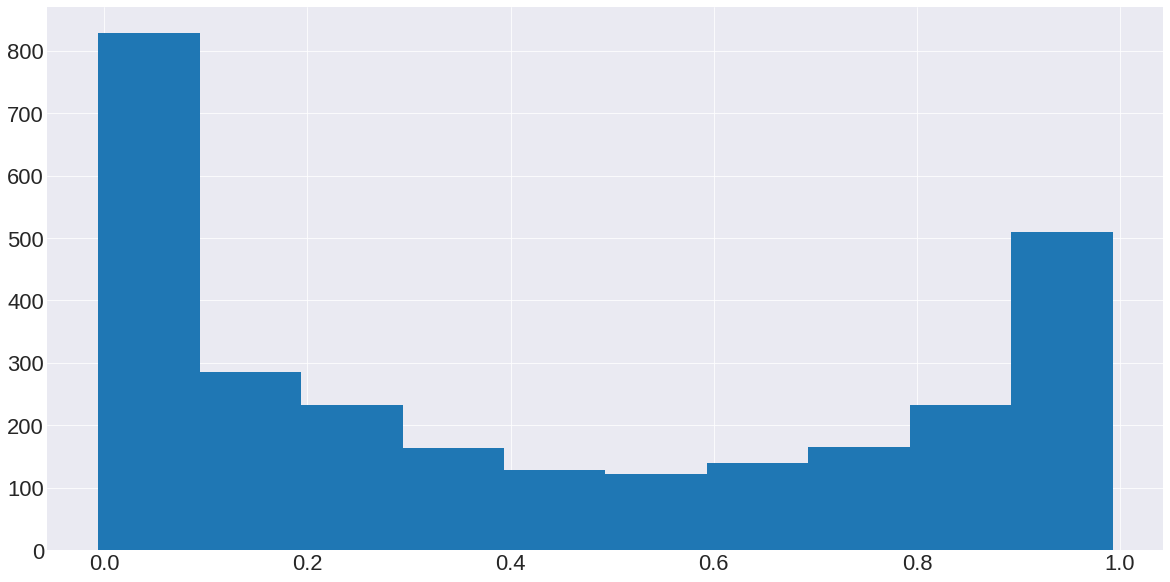

In [29]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.hist(corr, bins=10)
plt.show()

In [30]:
shapes = [corr[corr > p].shape[0] for p in p_vals]

In [31]:
shapes

[2441, 1966, 1674, 1445, 1289, 1164, 1042, 890, 732, 490]

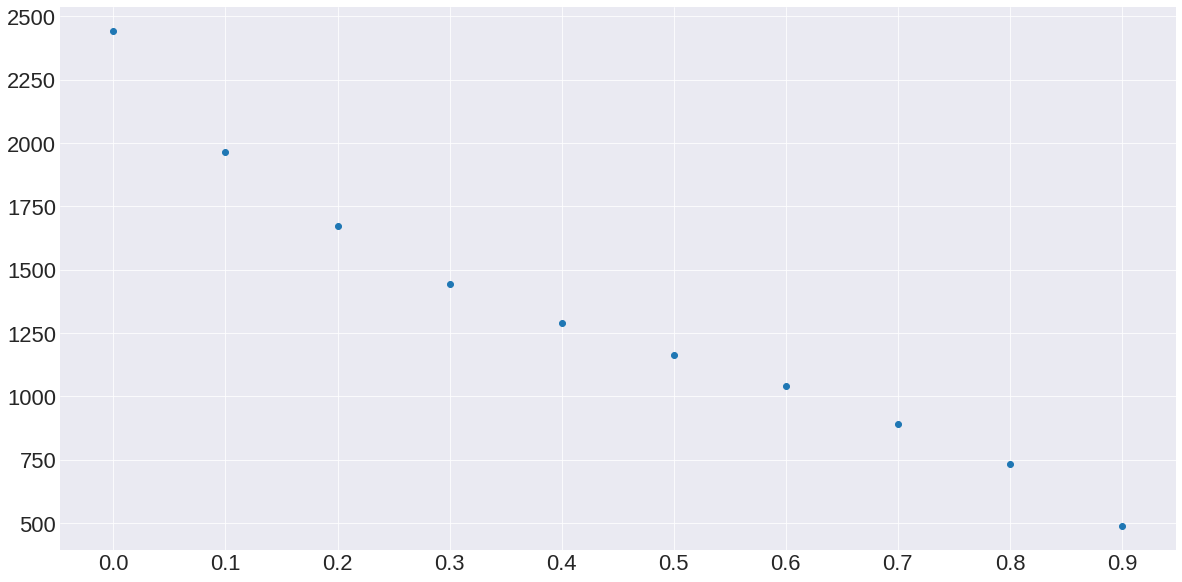

In [32]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.scatter(p_vals, shapes)
plt.xticks(p_vals)
# plt.yticks(shapes)
plt.show()

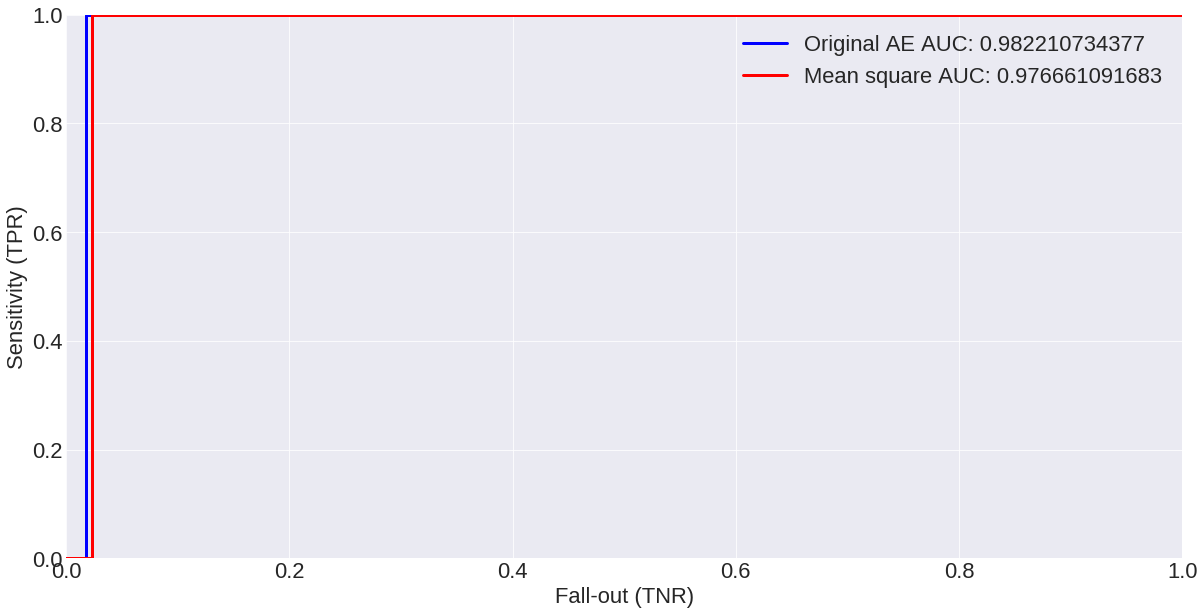

In [26]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = get_roc_curve_error(y_test,
                    [orig_ae_error,
                    get_error_df(X_test_norm, np.zeros(X_test_norm.shape), mode="topn", n_highest=100)], 
                    ['Original AE', 'Mean square'],
                    ['b', 'r'])

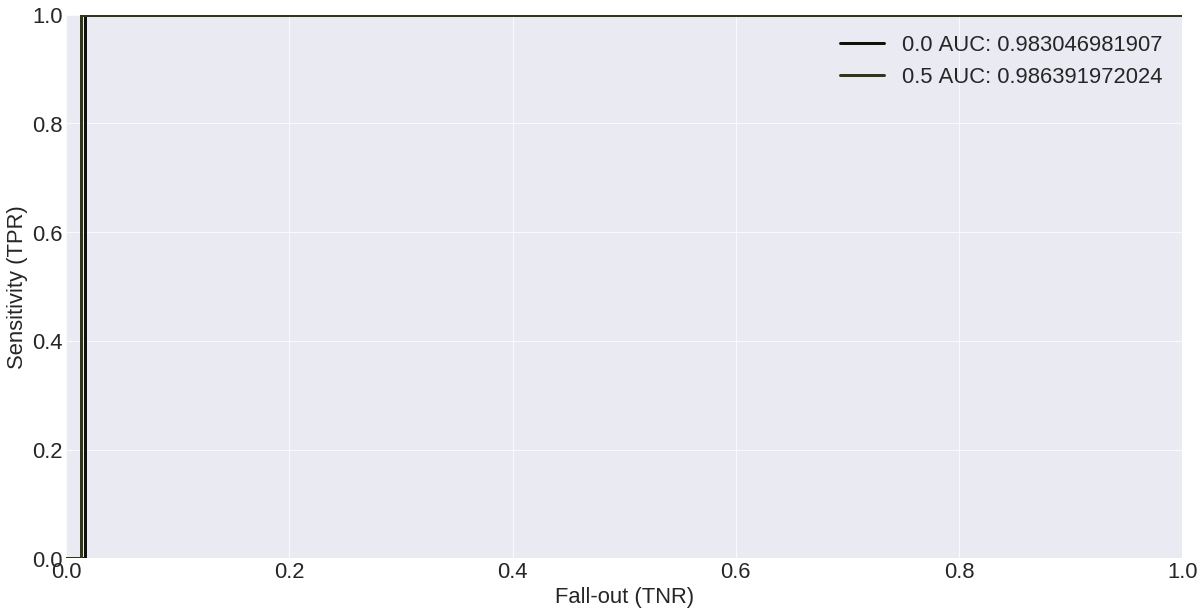

In [29]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = get_roc_curve_error(y_test,
                    reduced_ae_errors_top, 
                    [str(i) for i in p_vals],
                    colors)

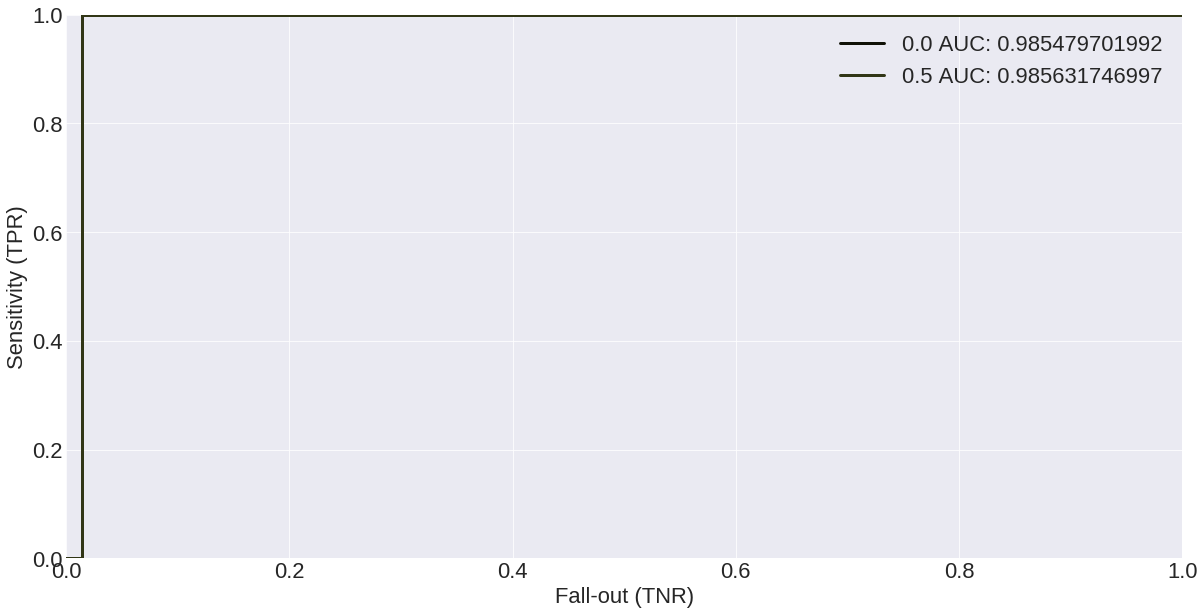

In [30]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = get_roc_curve_error(y_test,
                    reduced_ae_errors_allmean, 
                    [str(i) for i in p_vals],
                    colors)

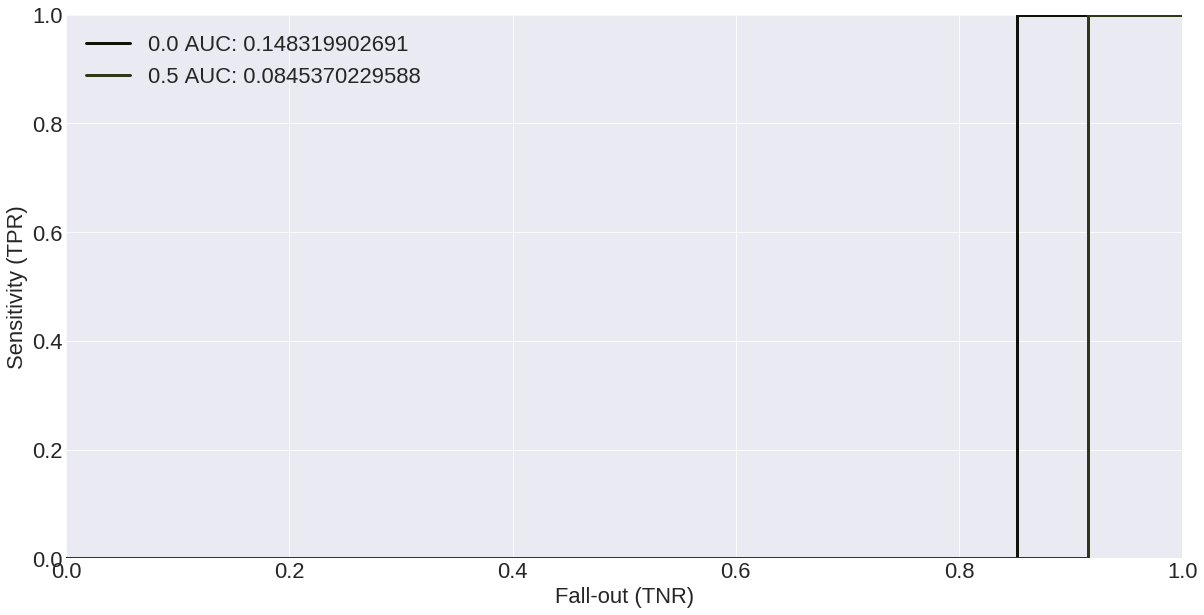

In [31]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = get_roc_curve_error(y_test,
                    reduced_ae_errors_bottom, 
                    [str(i) for i in p_vals],
                    colors)

In [37]:
# Plot lumi vs error
def plot_lumi_error(pred, X_test, threshold=None, title=None, max_height=1e4):
#     scores = get_error_df(X_test, pred, mode='topn')
    scores = pred
    
    fig, ax = plt.subplots()

    plt.plot(np.array([i for i in range(len(scores))])[y_test == 0],
             scores[y_test == 0],
             linestyle='',
             ms=2,
             marker='o',
             label="Outlier")

    plt.plot(np.array([i for i in range(len(scores))])[y_test == 1],
             scores[y_test == 1],
             linestyle='',
             ms=2,
             marker='o',
             label="Inlier")

    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    
    ax.set_yscale("log")
    plt.ylabel("Score")
    plt.xlabel("Lumisection #")
    if title:
        plt.title(title)
    plt.ylim(0, max_height)
    plt.show();

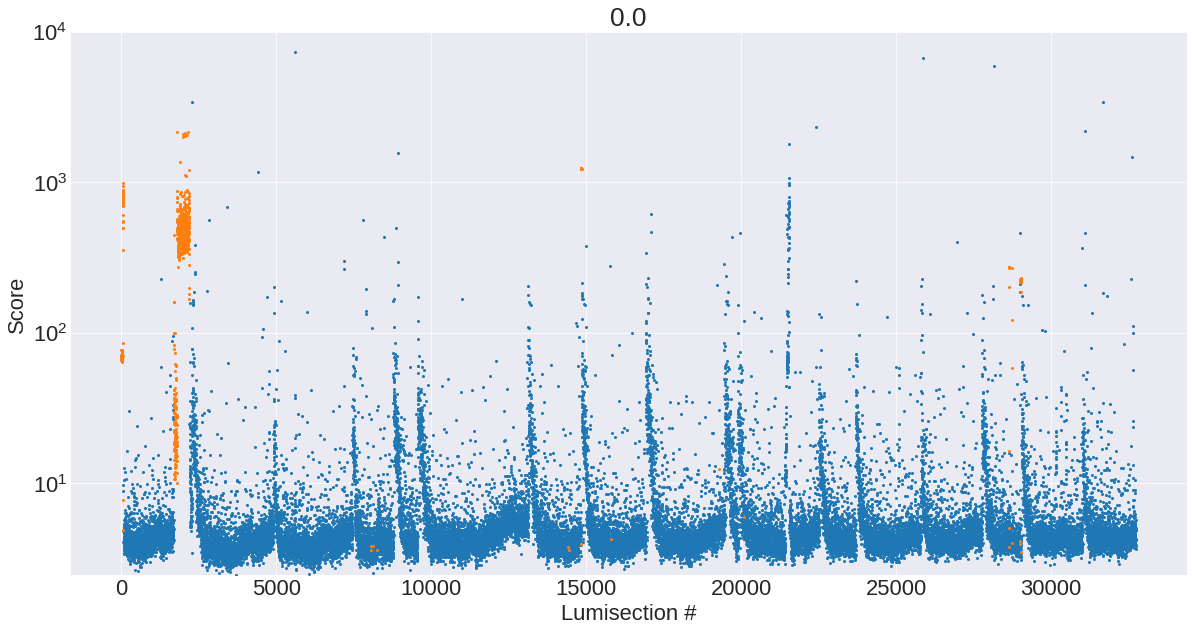

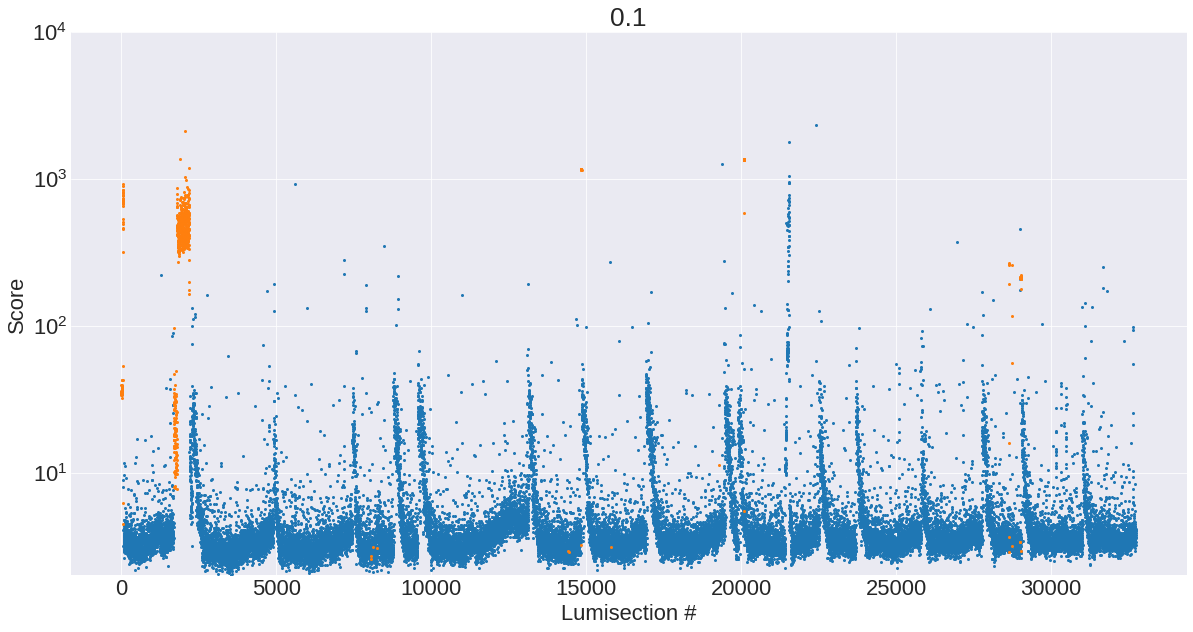

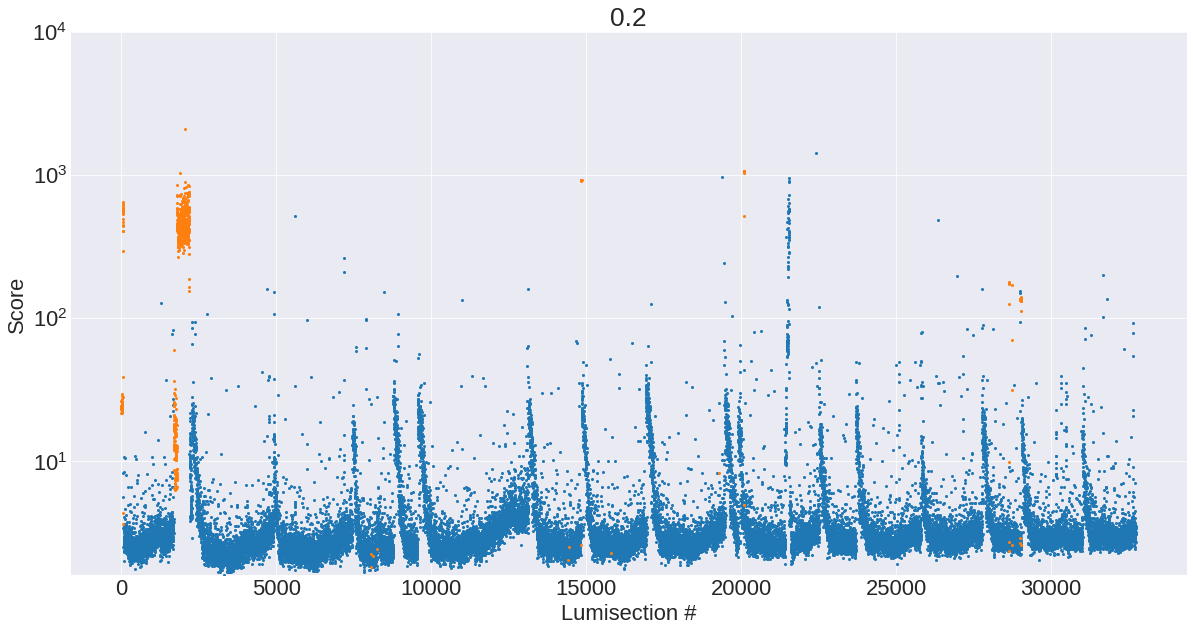

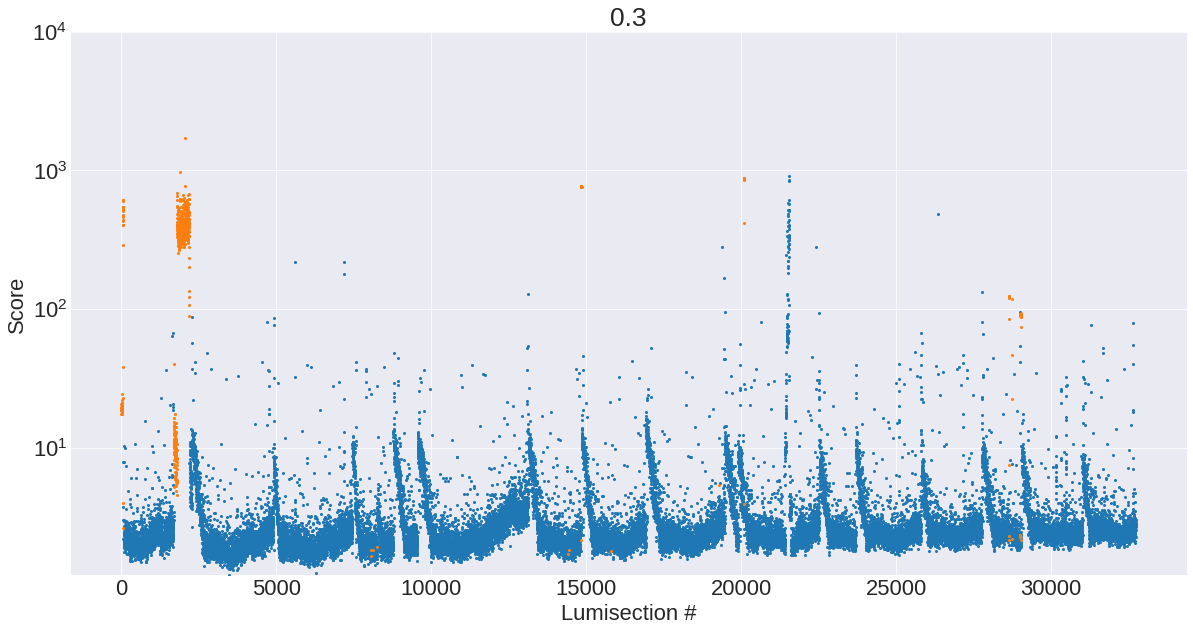

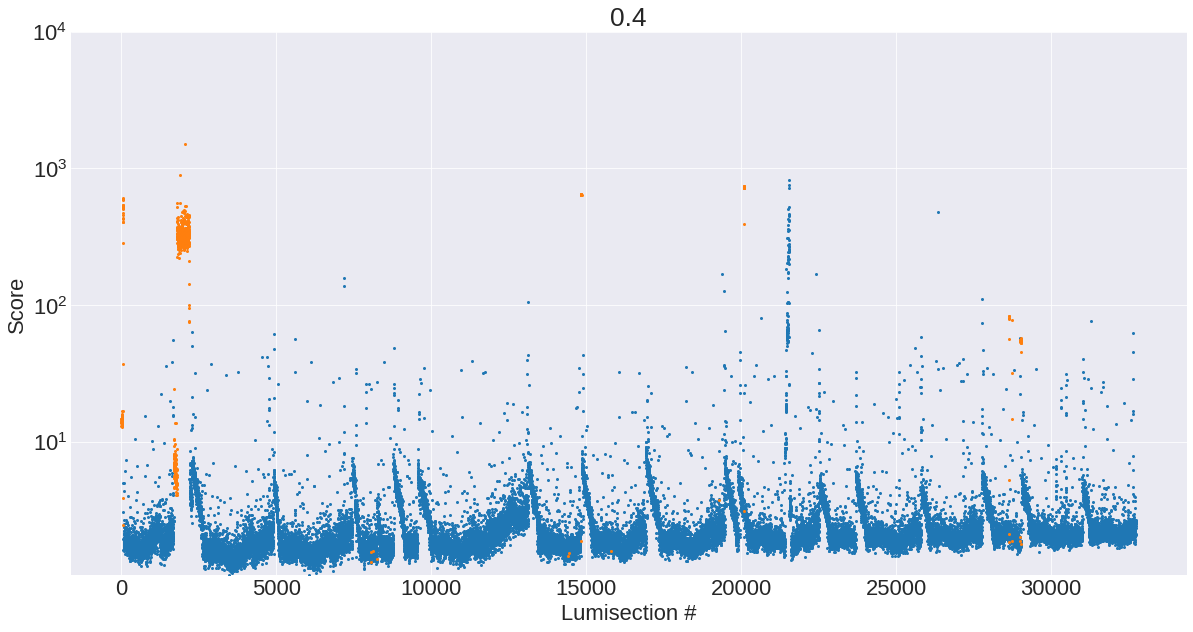

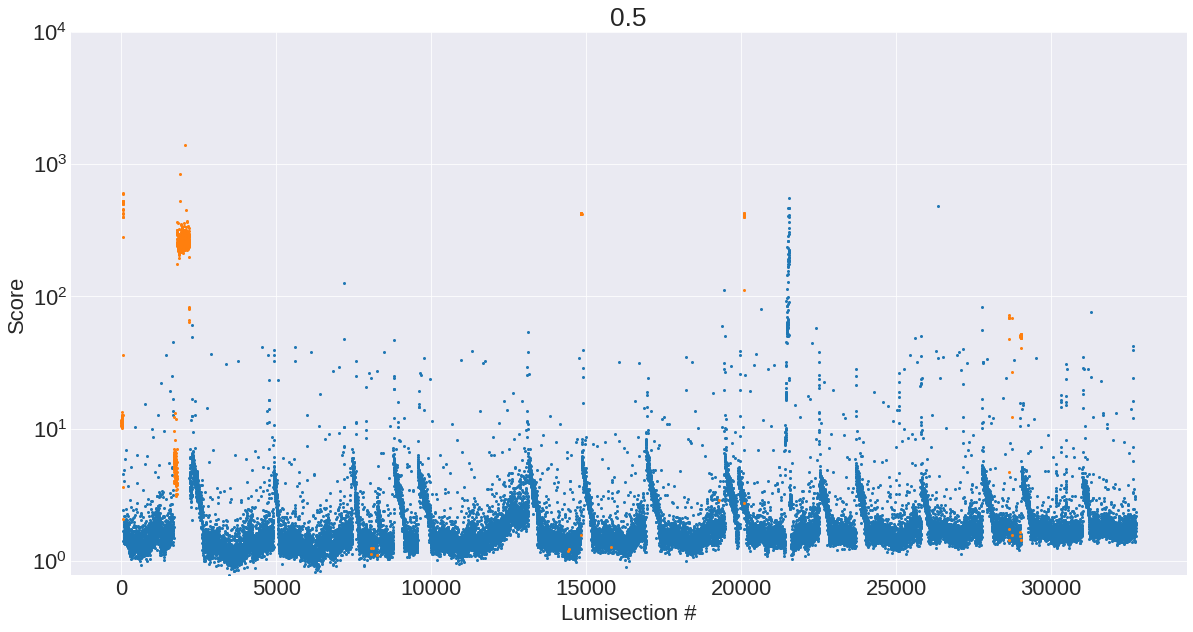

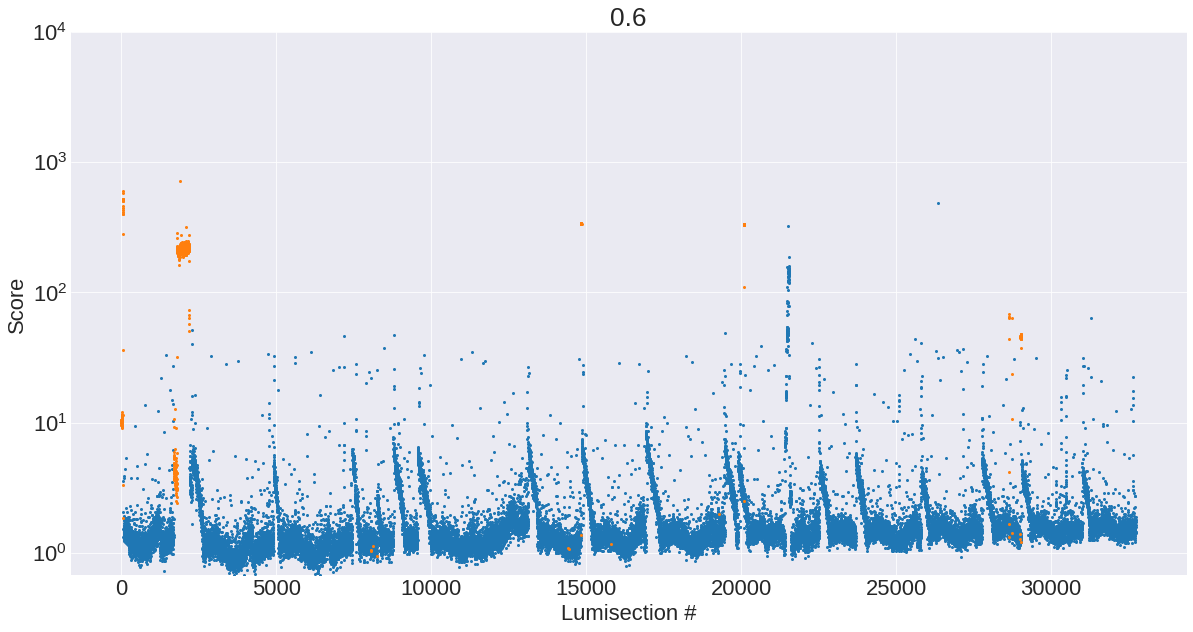

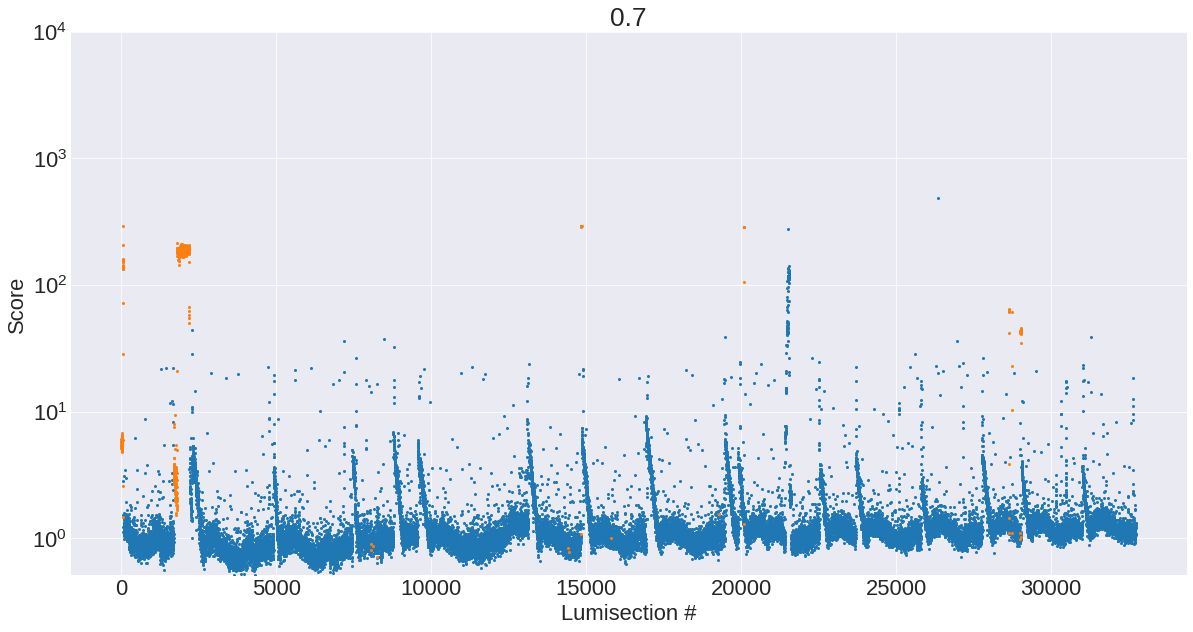

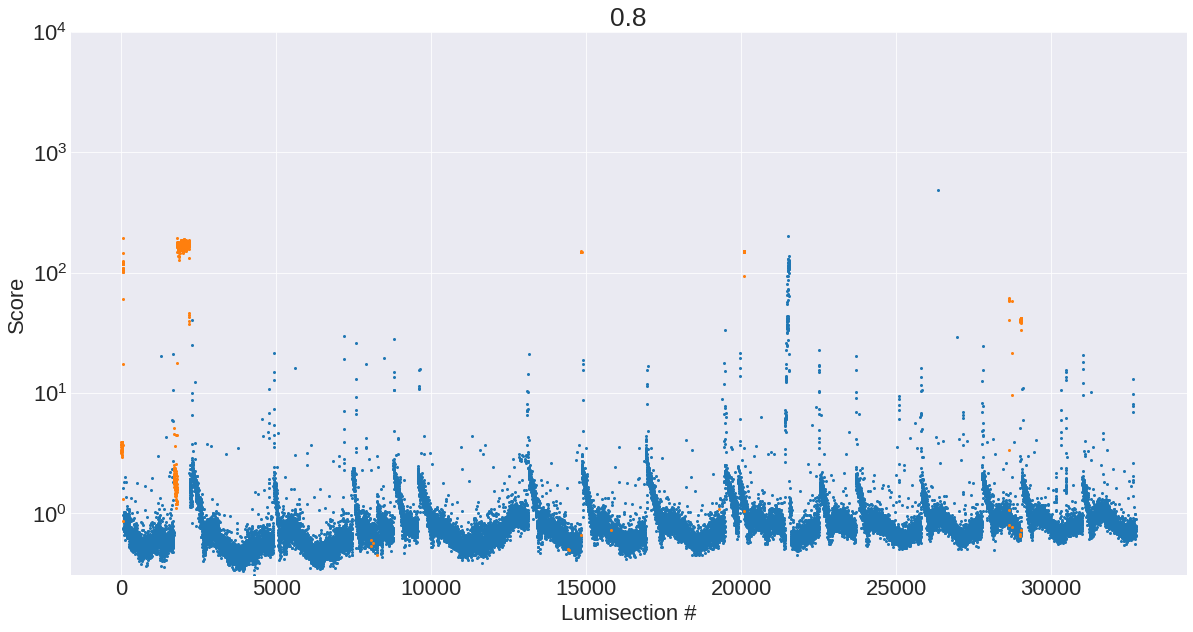

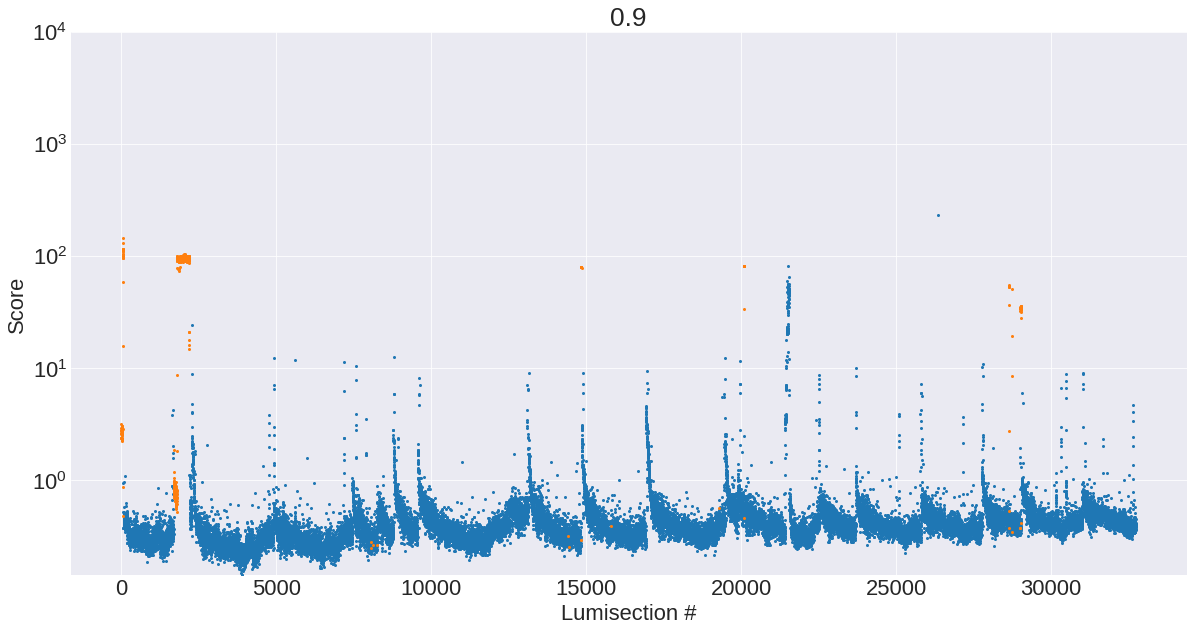

In [38]:
plt.rcParams['figure.figsize'] = [20, 10]
i = 0
for e in reduced_ae_errors_top:
    plot_lumi_error(e, X_test_norm, title=str(i/10))
    i += 1

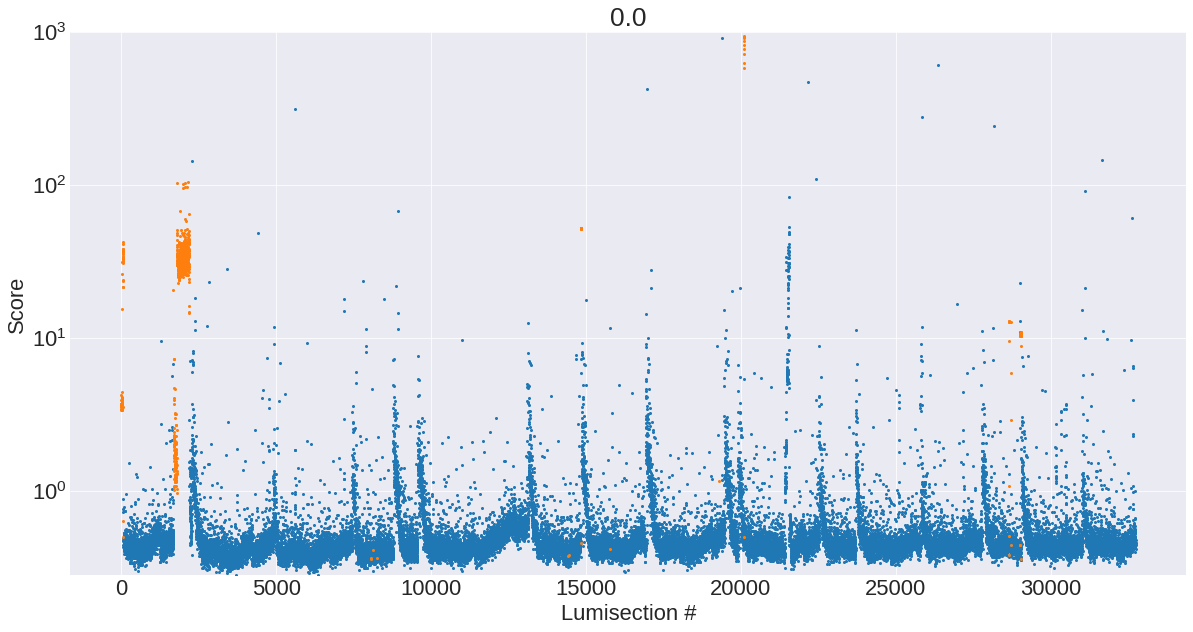

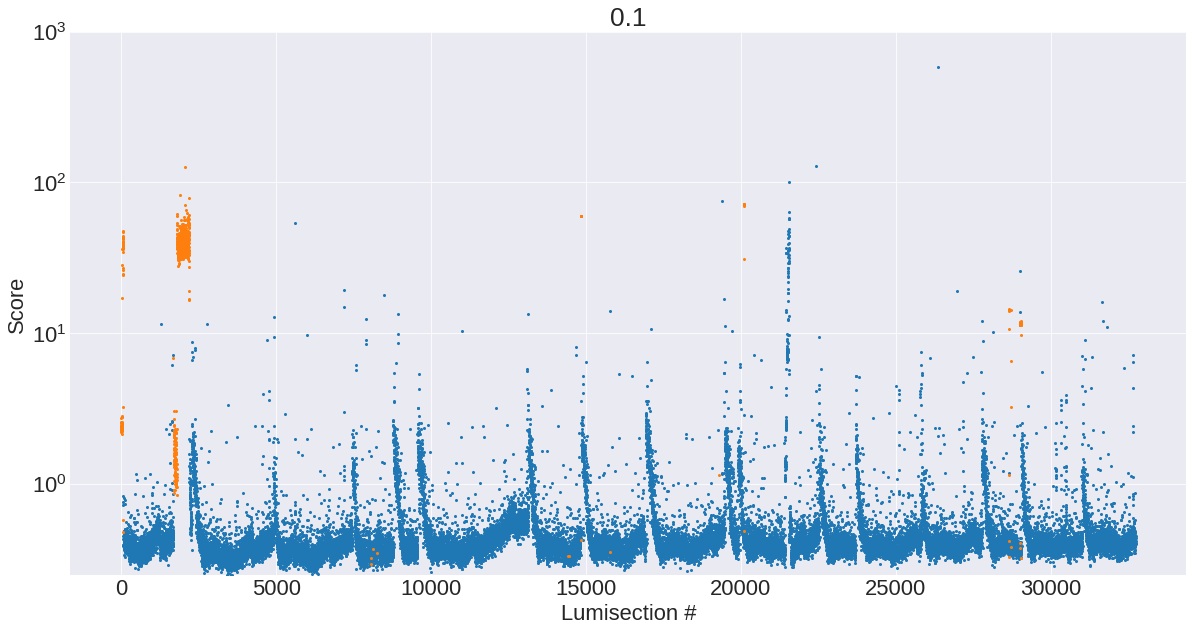

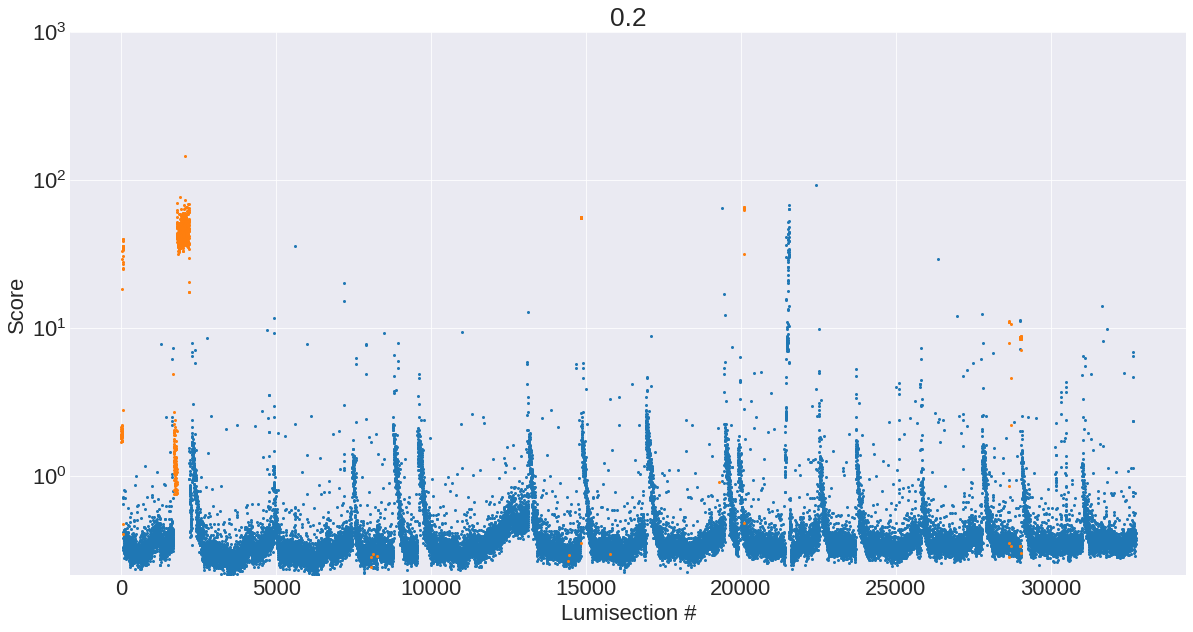

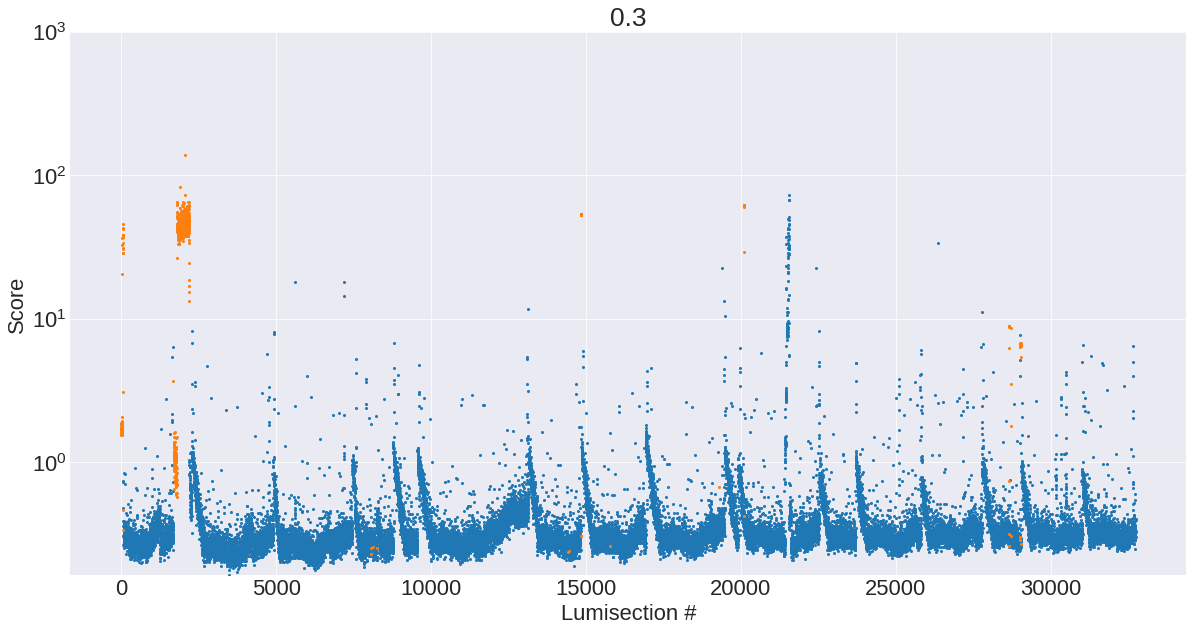

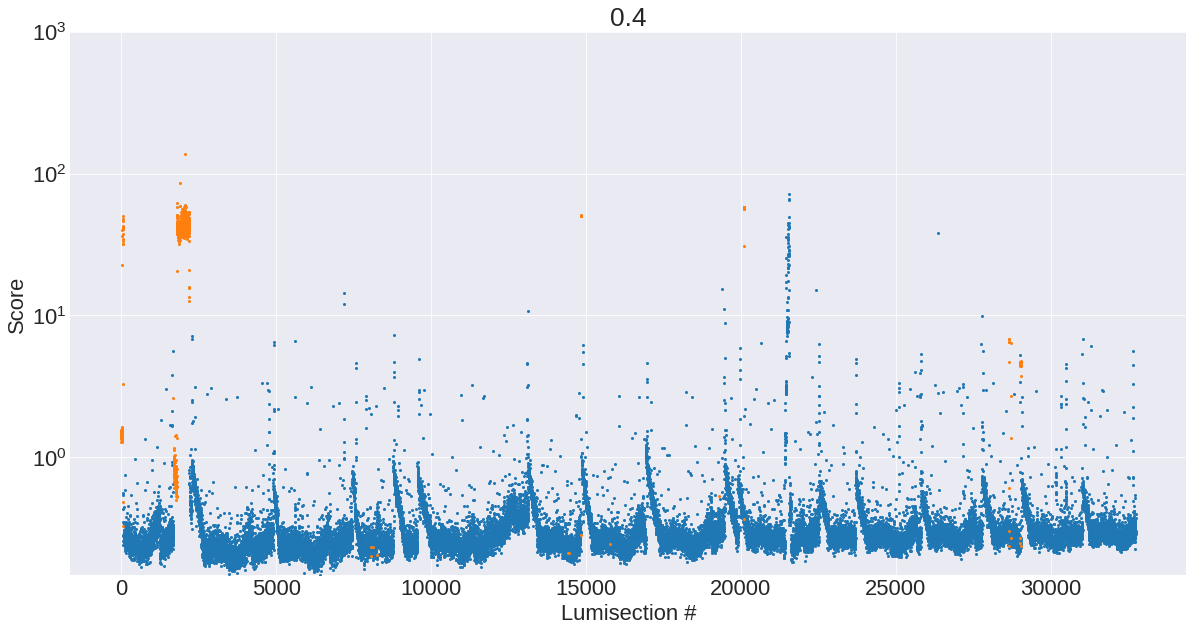

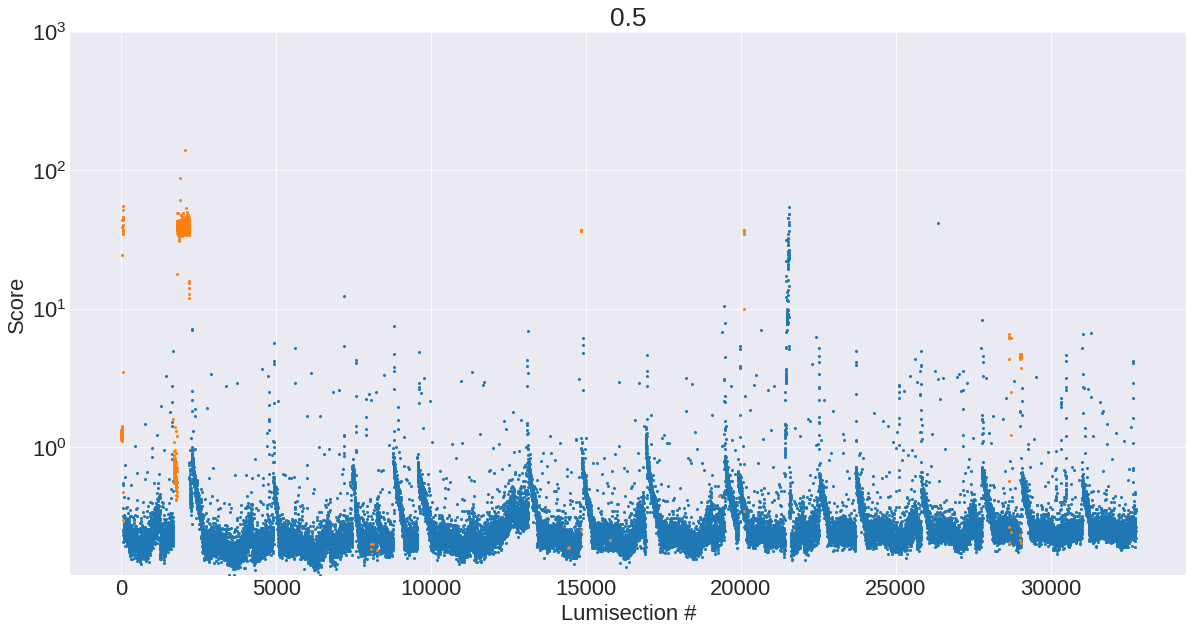

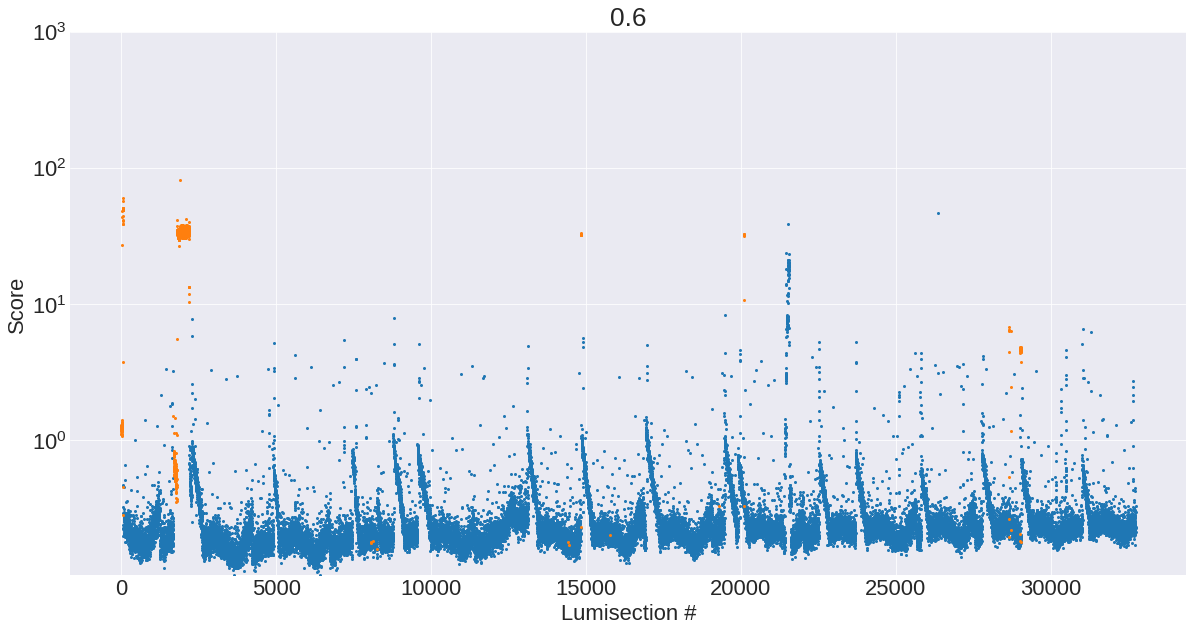

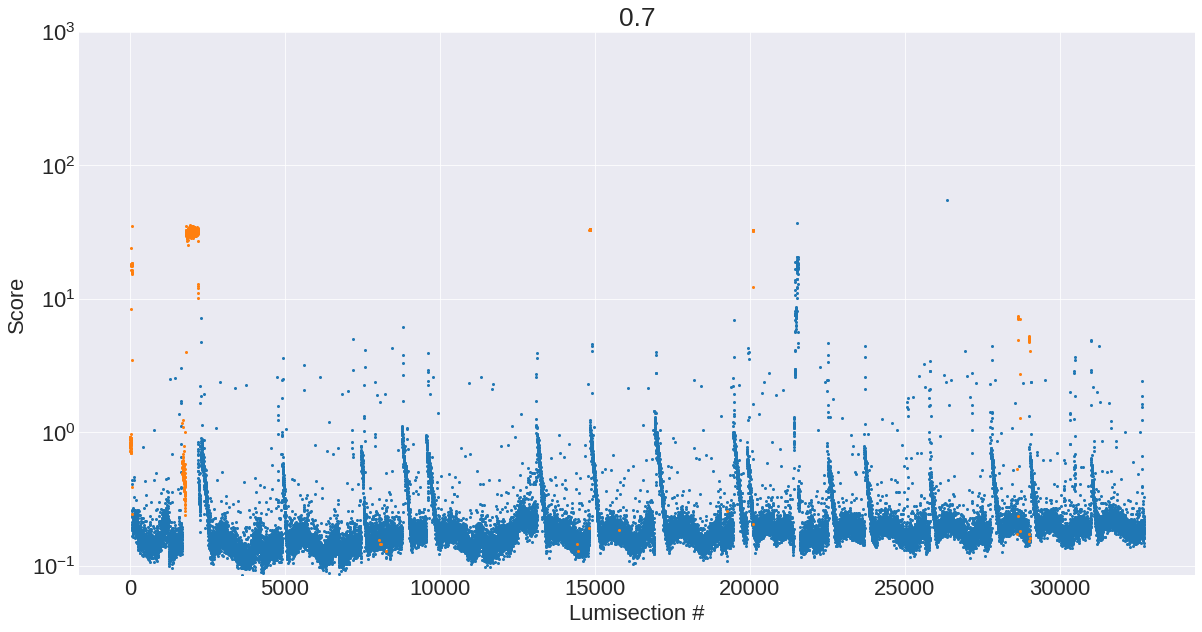

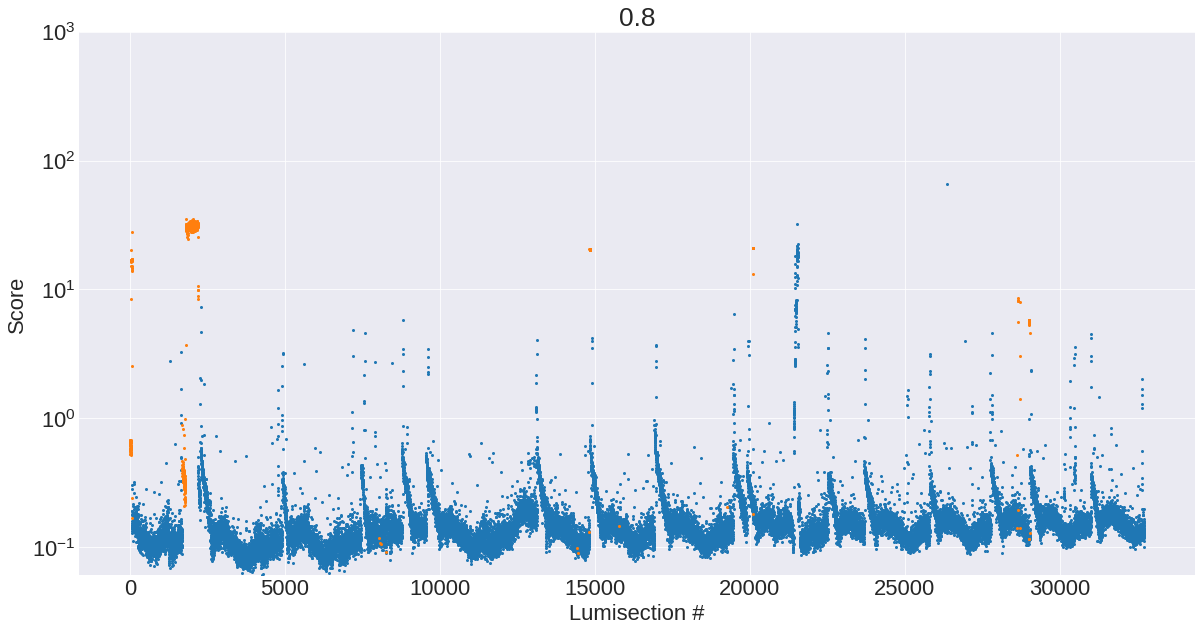

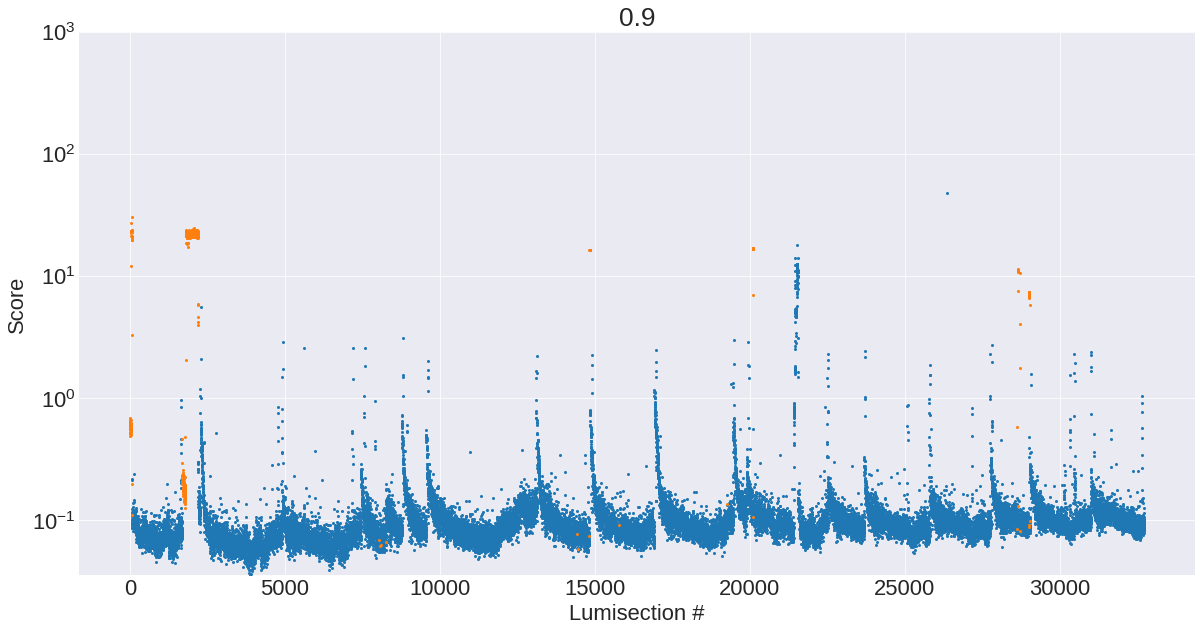

In [39]:
plt.rcParams['figure.figsize'] = [20, 10]
i = 0
for e in reduced_ae_errors_allmean:
    plot_lumi_error(e, X_test_norm, title=str(i/10), max_height=10e2)
    i += 1

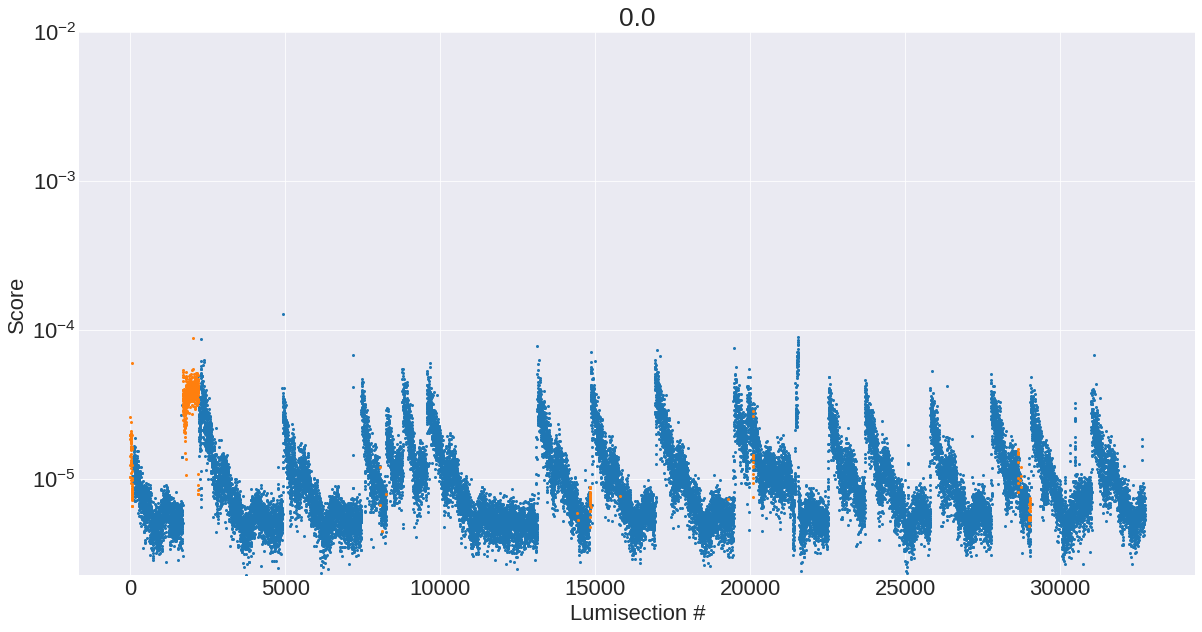

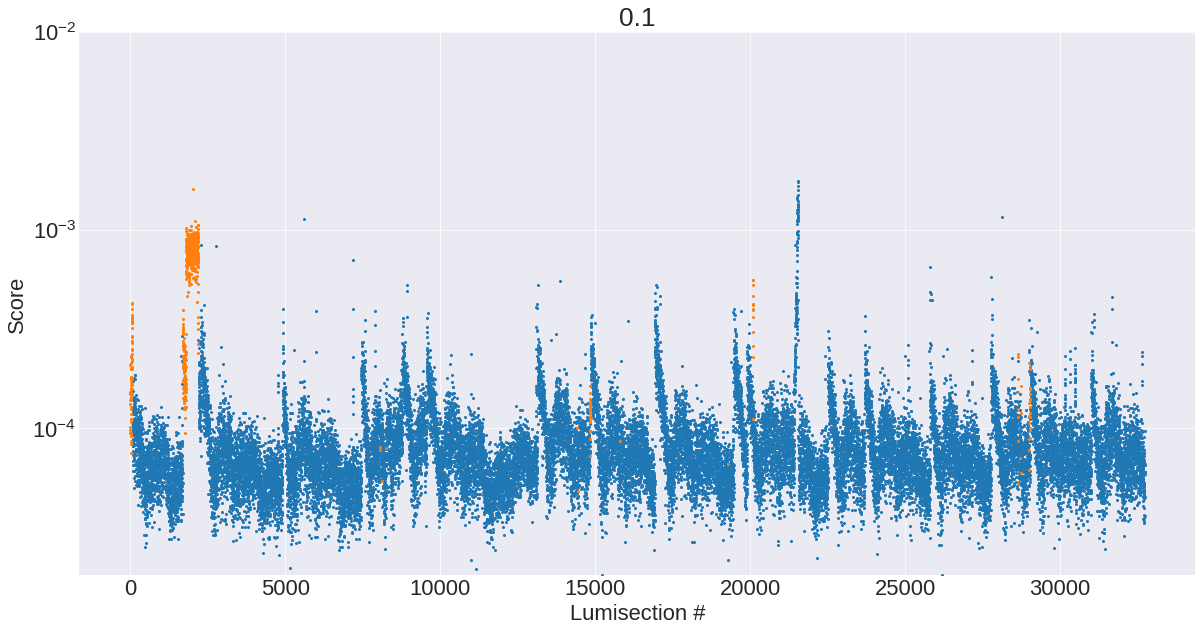

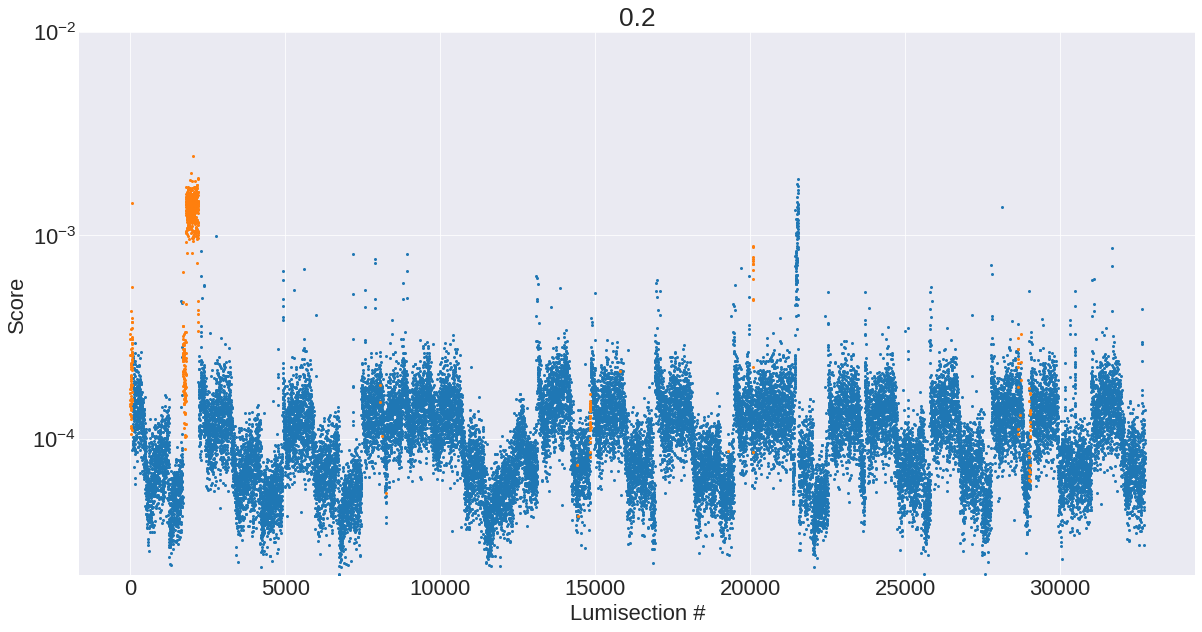

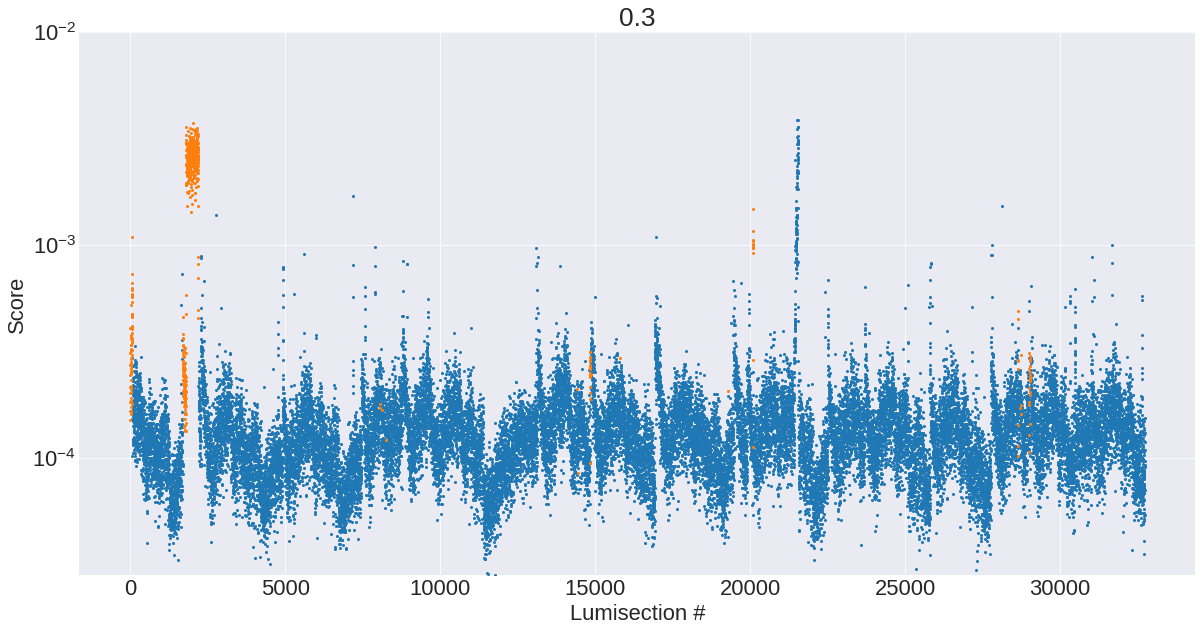

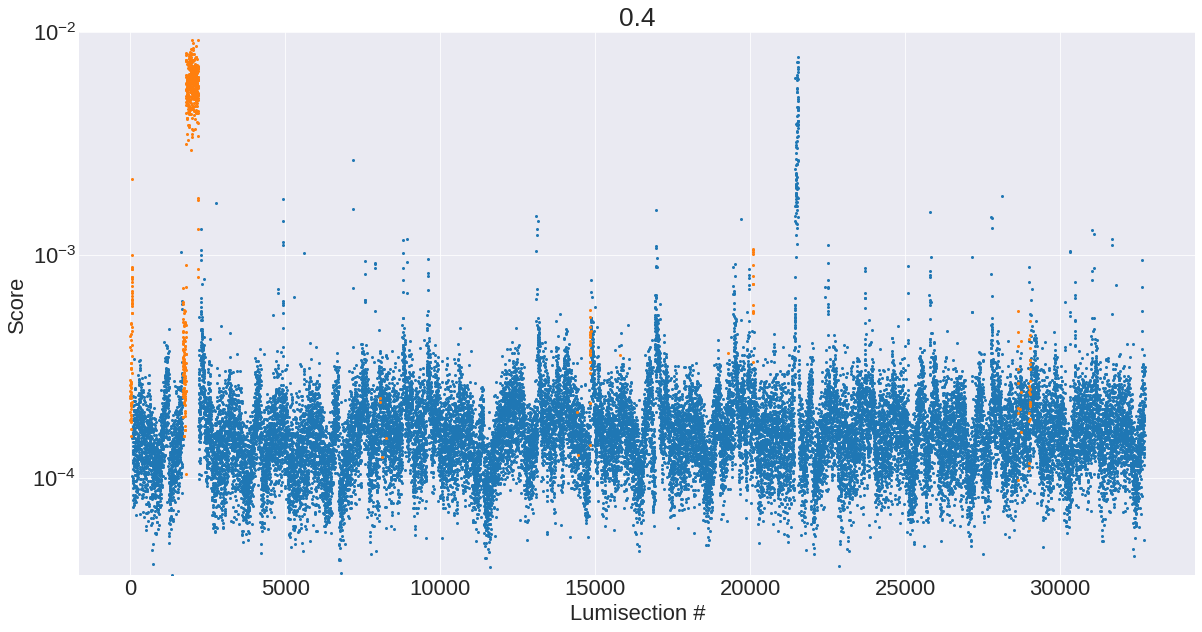

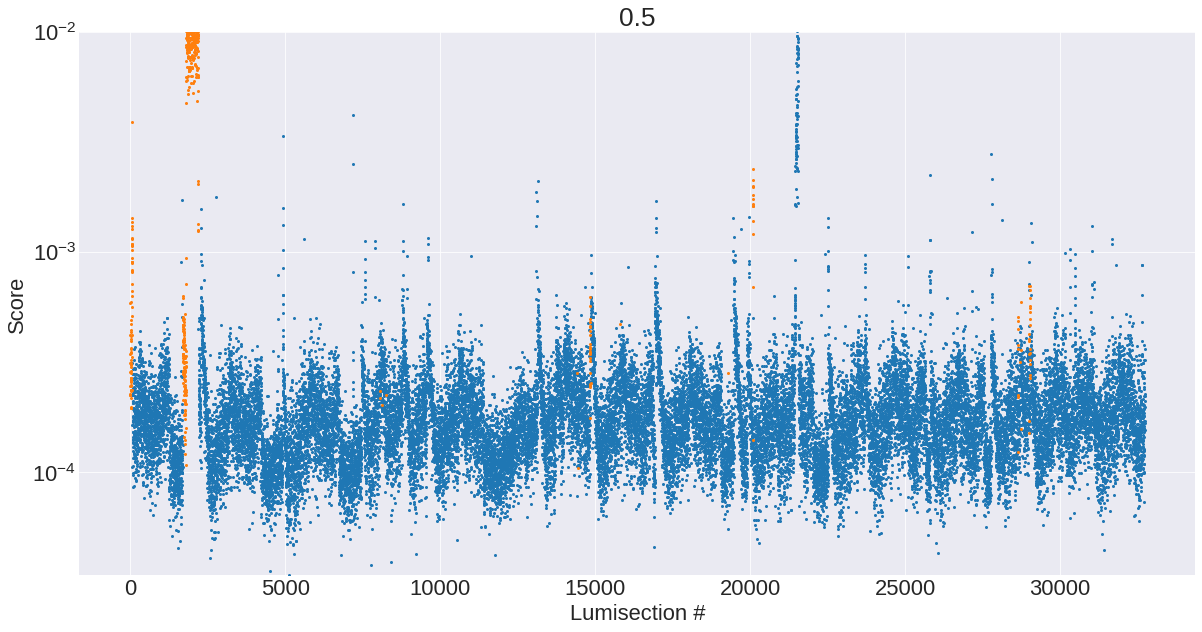

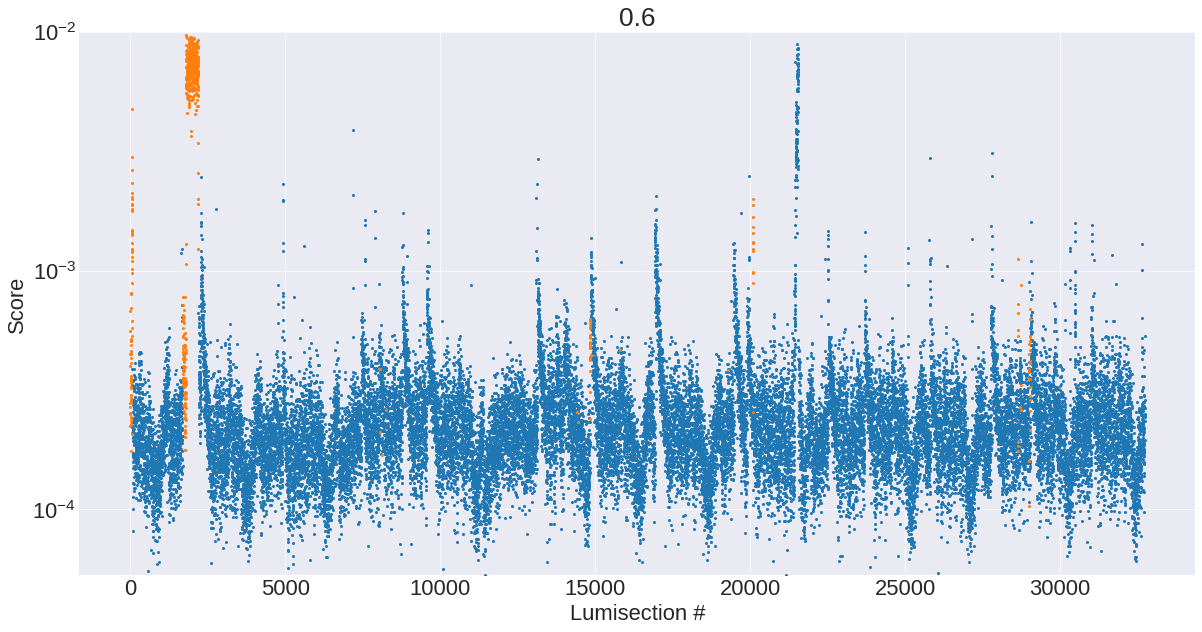

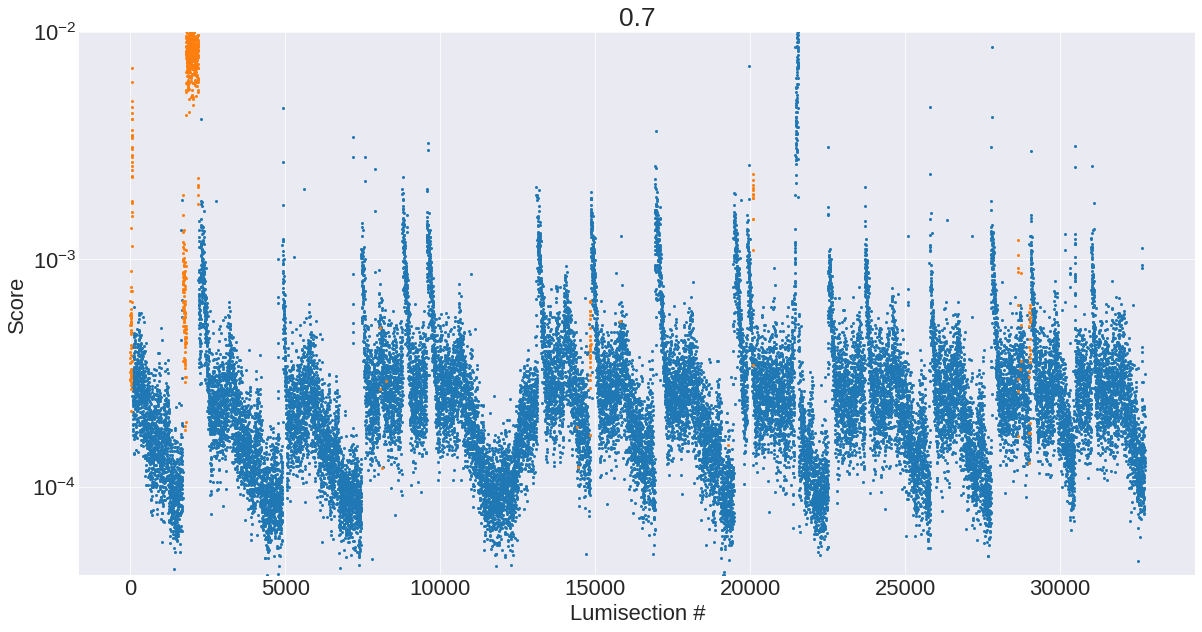

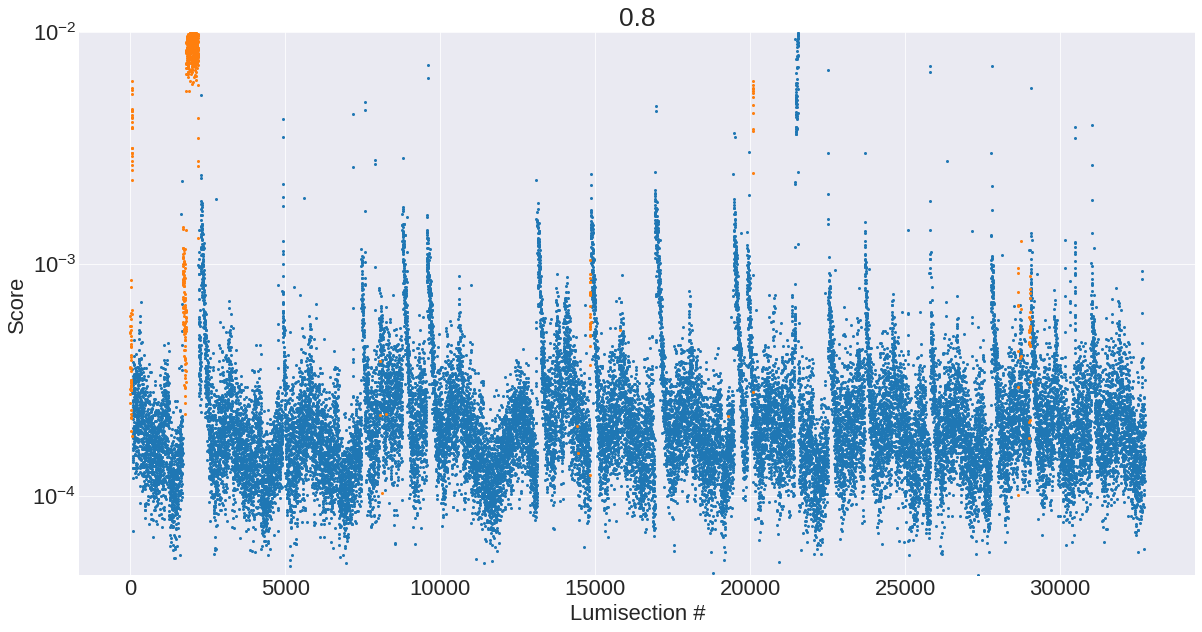

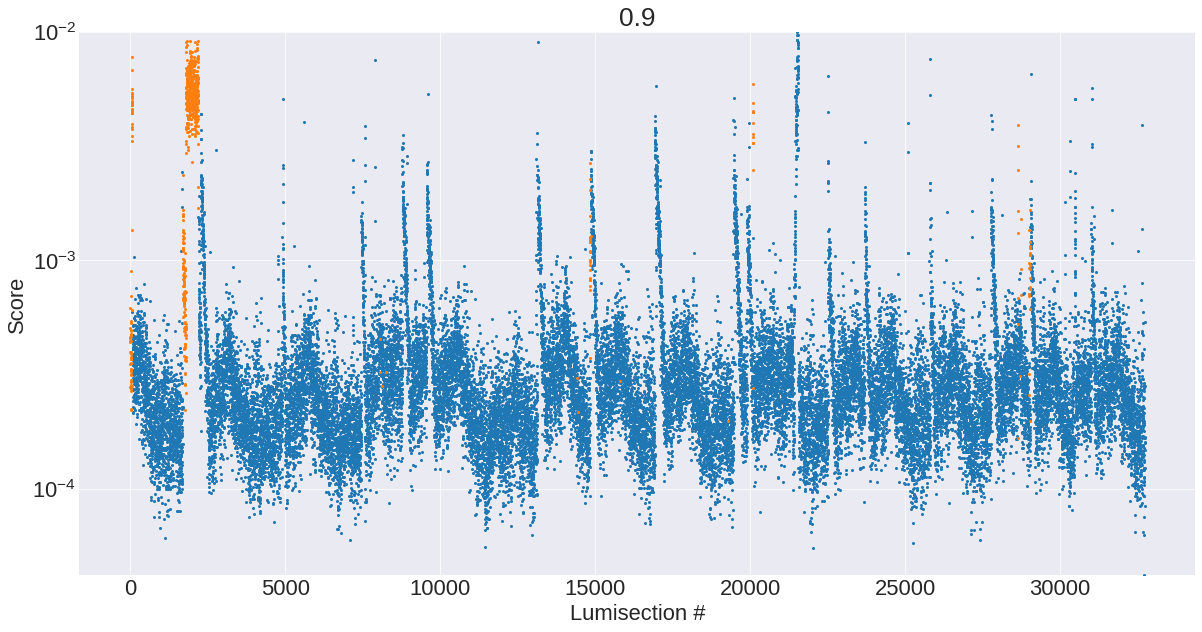

In [40]:
plt.rcParams['figure.figsize'] = [20, 10]
i = 0
for e in reduced_ae_errors_bottom:
    plot_lumi_error(e, X_test_norm, title=str(i/10), max_height=10e-3)
    i += 1

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

LABELS = ["Normal", "Anomalous"]

def conf_matrix(scores, y_true, threshold, title):
    y_pred = [1 if e > threshold else 0 for e in scores]
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(title)
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    class_imbal = np.mean(1 - y_true)
    adj_acc = (acc - class_imbal) / (1 - class_imbal)

    print("Threshold:", threshold)
    print("Adjusted accuracy:", adj_acc)
    return threshold

In [ ]:
conf_matrix(ae_error_filtered, y_test, 1.5e0, '')

In [ ]:
def pred_vs_feature(y_val, x_val, y_class, y_name="", x_name="", selected=[], linear=False,
                    limit=False):
    '''
    Plots two arbitrary values agains each other.
    '''
    df = pd.DataFrame({'y_val': y_val,
                       'x_val': x_val,
                       'y_class': y_class})

    groups = df.groupby('y_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.x_val, 
                group.y_val,
                color="red" if name == 1 else "blue",
                marker='o',
                ms=2,
                linestyle='',
                label= "Anomaly" if name == 1 else "Normal")

    for i in selected:
        ax.plot(x_val[i],
                y_val[i],
                color="green",
                marker='o',
                ms=4,
                linestyle='')
                 
    ax.legend()
    if not linear:
        ax.set_yscale('log')
    if limit:
        plt.xlim([limit[0], limit[1]])
    plt.grid()
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
pred_vs_feature(ae_error, X_test[2807], y_test, "AE reco error", "Luminosity")

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
pred_vs_feature(ae_error_filtered, X_test[2807], y_test, "AE reco error", "Luminosity")

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
pred_vs_feature(ae_error, X_test[2808], y_test, "AE reco error", "Luminosity")

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
pred_vs_feature(ae_error_filtered, X_test[2808], y_test, "AE reco error", "Luminosity")